In [1]:
%pylab inline
#%matplotlib qt
from __future__ import division # use so 1/2 = 0.5, etc.
import ssd
import scipy.signal as signal
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['savefig.dpi'] = 100 # default 72
#pylab.rcParams['figure.figsize'] = (6.0, 4.0) # default (6,4)
#%config InlineBackend.figure_formats=['png'] # default for inline viewing
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX

In [25]:
from IPython.display import display
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')
import sympy as sym
x,y,z,a,b,c,t = sym.symbols("x y z a b c t")

# Sinusoidal Angle Modulation Spectra

In [3]:
import scipy.special as special

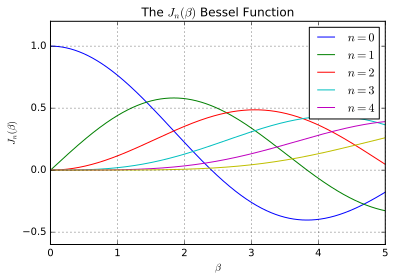

In [38]:
xj = arange(0,5,.001)
for n in range(6):
    plot(xj,special.jn(n,xj))
title(r'The $J_n(\beta)$ Bessel Function')
ylabel(r'$J_n(\beta)$')
xlabel(r'$\beta$')
legend((r'$n=0$',r'$n=1$',r'$n=2$',r'$n=3$',r'$n=4$'),loc='best')
grid();

## Plot Spectra

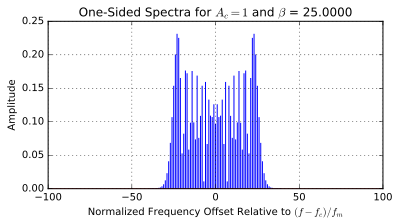

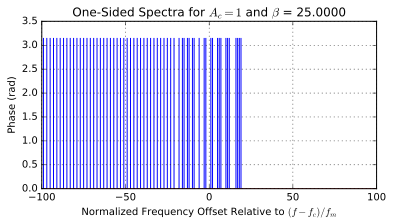

In [39]:
#beta = 2.4048
beta = 25
Nterms = 100
idx = arange(-Nterms,Nterms+1)
Yn = special.jn(idx,beta)
figure(figsize=(6,3))
stem(idx,abs(Yn),markerfmt=" ")
grid();
ylabel(r'Amplitude')
xlabel(r'Normalized Frequency Offset Relative to $(f-f_c)/f_m$')
title(r'One-Sided Spectra for $A_c=1$ and $\beta$ = %2.4f' % beta);
figure(figsize=(6,3))
stem(idx,angle(Yn),markerfmt=" ")
grid();
ylabel(r'Phase (rad)')
xlabel(r'Normalized Frequency Offset Relative to $(f-f_c)/f_m$')
title(r'One-Sided Spectra for $A_c=1$ and $\beta$ = %2.4f' % beta);

# Bandwidth Calculation

In [40]:
beta = 75
n = arange(0,100)
J_beta15=special.jn(n,beta)

Find the power in 11 sidebands total centered onthe carrier. The given signal power is $A_c^2/2 = 5000$ W. We must find:
\begin{align}
    P_\text{out} &= \frac{A_c^2}{2}\left[J_0^2(\beta) + 2\sum_{n=1}^5 J_n^2(\beta)\right] \\
\end{align}
for $A_c^2/2 = 5000$W and $\beta = 75$.

In [41]:
Pout = 5000*(J_beta15[0]**2 + 2*sum(J_beta15[1:6]**2))
print('Power contained in 11 Hz bandwidth = %4.4f W.' % Pout)

Power contained in 11 Hz bandwidth = 241.9323 W.


## Bandlimited Noise PM and FM

Following notes Example 4.6 we set up the following simulation:

In [261]:
fs = 10000
b,a = signal.butter(12,2*1000/fs)

In [262]:
w = randn(100000)
x = signal.lfilter(b,a,w)
fd = 1.0
#xc = exp(2*pi*1j*fd*x)
xc = exp(2*pi*1j*fd*cumsum(x))

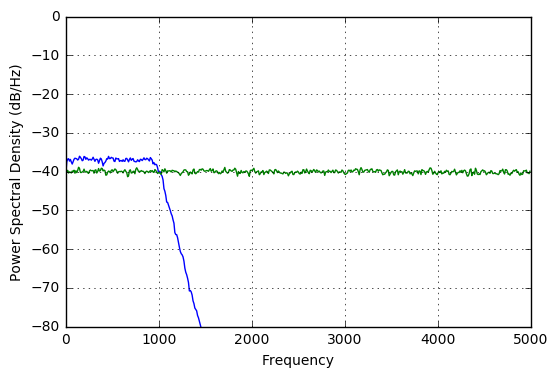

In [263]:
psd(x,2**10,fs);
ylim([-80,0])
psd(xc,2**10,fs)
xlim([0,fs/2]);

# Demodulation of Angle Modulation

## Complex Baseband Discriminator

In [264]:
def discrim(x):
    """
    function disdata = discrim(x)
    where x is an angle modulated signal in complex baseband form.
    
    Mark Wickert
    """
    X=np.real(x)        # X is the real part of the received signal
    Y=np.imag(x)        # Y is the imaginary part of the received signal
    b=np.array([1, -1]) # filter coefficients for discrete derivative
    a=np.array([1, 0])  # filter coefficients for discrete derivative
    derY=signal.lfilter(b,a,Y)  # derivative of Y, 
    derX=signal.lfilter(b,a,X)  #    "          X,
    disdata=(X*derY-Y*derX)/(X**2+Y**2)
    return disdata

To test the `discrim()` function I generate a complex baseband angle modulated signal of the form
\begin{align}
    x(t) = e^{j\beta \cos(2\pi f_m t)}
\end{align}
which is related to the real angle modulated signal $x_c(t)$ via
\begin{align}
    x_c(t) &= \cos\big[2\pi f_c t + \beta \cos(2\pi f_m t)\big]\\
    &= \text{Re} \left\{e^{j2\pi f_c t}\cdot \underbrace{e^{j\beta \cos(2\pi f_m t)}}_{x(t)}\right\}.
\end{align}
The complex baseband signal is passed through the discriminator function to recover the angle modulation.

In [265]:
fs = 50000
n = arange(0,10000)
m = cos(2*pi*n*1000/fs)
xc = exp(1j*2.4048*m)*exp(1j*2*pi*500/fs*n)
yD = discrim(xc)

Form and estmate of the power spectral density (not simply the spectrum or Fourier transform) of `xc`. You see from the plot below that the spectrum appears as a line spectrum just the power spectrum for any other periodic signal dealt with in Chapter 2. The signal is indeed complex as it is formed from a complex sinusoid.

(-100, -20)

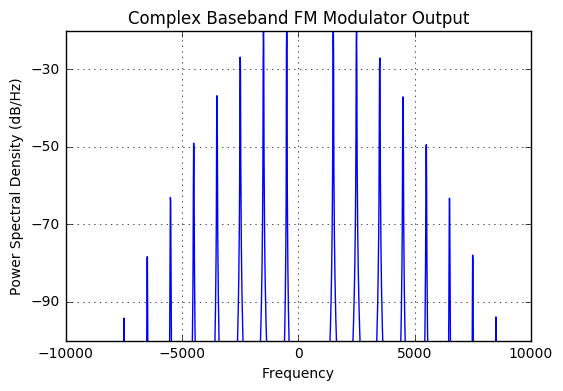

In [266]:
psd(xc,2**12,fs);
title(r'Complex Baseband FM Modulator Output')
xlim([-10000,10000])
ylim([-100,-20])

Below you see the sinsusoidal is message is recovered:

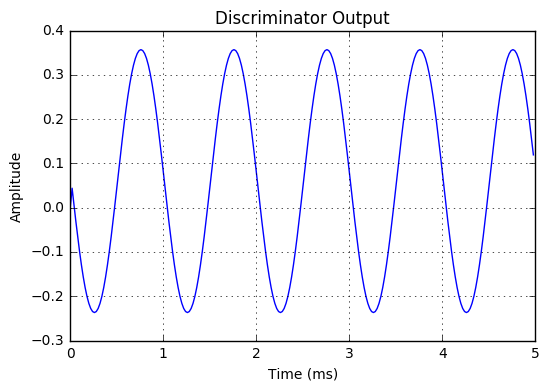

In [267]:
t = n/fs*1e3 # units of ms
Nmax = 250
plot(t[:Nmax],yD[:Nmax])
title(r'Discriminator Output')
ylabel(r'Amplitude')
xlabel(r'Time (ms)')
grid();

# Slope Detector
The slope detector form of FM demodulator uses the gain slope of a filter, say highpass or bandpass, to convert frequency deviation to amplitude fluctuations. An envelope detector can then recover the FM modulation converted to AM modulation.

Here we consider a Butterworth highpass filter, implemented as a digital filter for further use in simulation. In particular use a 5th-order design.

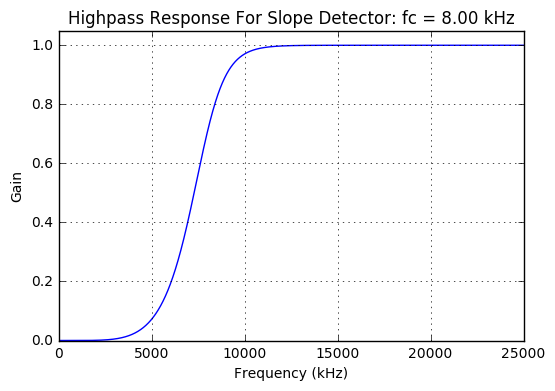

In [268]:
fs = 50000
fc = 8000
b,a = signal.butter(5,2*fc/fs,'high')
f = arange(0,25000,10)
w,H = signal.freqz(b,a,2*pi*f/fs)
plot(f,abs(H))
title(r'Highpass Response For Slope Detector: fc = %1.2f kHz' % (fc/1000,))
ylabel(r'Gain')
xlabel(r'Frequency (kHz)')
ylim([0,1.05])
grid();

## FM Modulator Using a Non-Zero Carrier Frequency
First generate an FM signal on a carrier frequency of 10 kHz. Use single tone FM with $f_m = 100$ Hz and $f_D = 100$ as starting points.

In [269]:
n = arange(0,10000)
fm = 200
m = cos(2*pi*100/fs*n)
f0 = 7000
fD = 100
xc = cos(2*pi*f0/fs*n + 2*pi*fD/fm*m)

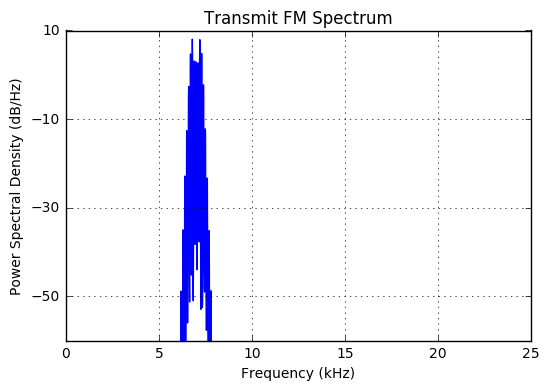

In [270]:
psd(xc,2**12,fs/1000);
ylim([-60,10])
xlabel(r'Frequency (kHz)')
title(r'Transmit FM Spectrum')

## Pass the FM Signal Through the Highpass FIlter
Next we highpass filter the FM signal which will introduce envelope fluctuations in the carrier envelope, as the filter gain slope is passing right through $f_0 = 7$ kHz. Following that we envelope detect to recover the FM that has been converted to AM.

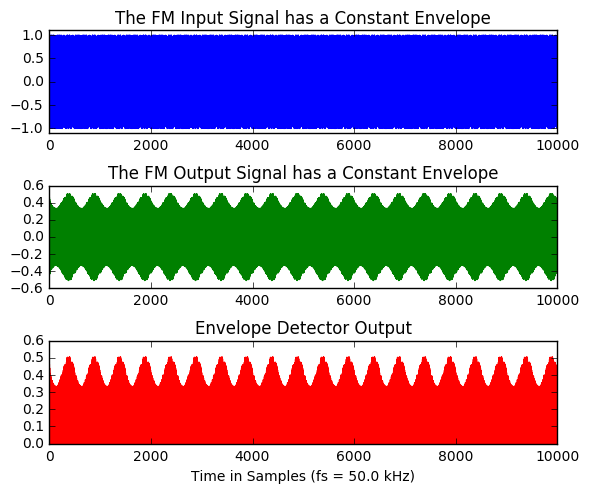

In [271]:
yc = signal.lfilter(b,a,xc)
figure(figsize=(6,5))
subplot(311)
plot(n,xc)
ylim([-1.1,1.1])
title(r'The FM Input Signal has a Constant Envelope')
subplot(312)
plot(n,yc,'g')
title(r'The FM Output Signal has a Constant Envelope')
subplot(313)
plot(n,yc*(1+sign(yc))/2,'r')
title(r'Envelope Detector Output')
xlabel(r'Time in Samples (fs = %1.1f kHz)' % (fs/1000,))
tight_layout()

# Phase Locked Loops

In [14]:
import synchronization as pll
#reload(pll)

<module 'synchronization' from 'synchronization.pyc'>

The module `synchronization.py` contains PLLs in addition to digital communications synchronization algorithms. One of the functions inside this module is `PLL1`, listed below

```python
def PLL1(theta,fs,loop_type,Kv,fn,zeta,non_lin):
    """
    theta_hat, ev, phi = PLL1(theta,fs,loop_type,Kv,fn,zeta,non_lin)
    Baseband Analog PLL Simulation Model
    ===================================================================
        theta = input phase deviation in radians
           fs = sampling rate in sample per second or Hz
    loop_type = 1, first-order loop filter F(s)=K_LF; 2, integrator 
                with lead compensation F(s) = (1 + s tau2)/(s tau1), 
                i.e., a type II, or 3, lowpass with lead compensation
                F(s) = (1 + s tau2)/(1 + s tau1)
           Kv = VCO gain in Hz/v; note presently assume Kp = 1v/rad 
                and K_LF = 1; the user can easily change this
           fn = Loop natural frequency (loops 2 & 3) or cutoff 
                frquency (loop 1)
         zeta = Damping factor for loops 2 & 3
      non_lin = 0, linear phase detector; 1, sinusoidal phase detector
    +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    theta_hat = Output phase estimate of the input theta in radians
           ev = VCO control voltage
          phi = phase error = theta - theta_hat
    ===================================================================
    Alternate input in place of natural frequency, fn, in Hz is
    the noise equivalent bandwidth Bn in Hz.
    ===================================================================
    Mark Wickert, April 2007 for ECE 5625/4625
    Modified February 2008 and July 2014 for ECE 5675/4675
    Python version August 2014
    """
    T = 1/float(fs)
    Kv = 2*np.pi*Kv # convert Kv in Hz/v to rad/s/v

    if loop_type == 1:
        # First-order loop parameters
        # Note Bn = K/4 Hz but K has units of rad/s
        #fn = 4*Bn/(2*pi);
        K = 2*np.pi*fn # loop natural frequency in rad/s
    elif loop_type == 2:
        # Second-order loop parameters
        #fn = 1/(2*pi) * 2*Bn/(zeta + 1/(4*zeta));
        K = 4 *np.pi*zeta*fn # loop natural frequency in rad/s
        tau2 = zeta/(np.pi*fn)
    elif loop_type == 3:
        # Second-order loop parameters for one-pole lowpass with
        # phase lead correction.
        #fn = 1/(2*pi) * 2*Bn/(zeta + 1/(4*zeta));
        K = Kv # Essentially the VCO gain sets the single-sided
                # hold-in range in Hz, as it is assumed that Kp = 1
                # and KLF = 1.
        tau1 = K/((2*np.pi*fn)^2);
        tau2 = 2*zeta/(2*np.pi*fn)*(1 - 2*pi*fn/K*1/(2*zeta))
    else:
        print('Loop type must be 1, 2, or 3')

    # Initialize integration approximation filters
    filt_in_last = 0; filt_out_last = 0;
    vco_in_last = 0; vco_out = 0; vco_out_last = 0;

    # Initialize working and final output vectors
    n = np.arange(len(theta))
    theta_hat = np.zeros_like(theta)
    ev = np.zeros_like(theta)
    phi = np.zeros_like(theta)

    # Begin the simulation loop
    for k in  xrange(len(n)):
        phi[k] = theta[k] - vco_out
        if non_lin == 1:
            # sinusoidal phase detector
            pd_out = np.sin(phi[k])
        else:
            # Linear phase detector
            pd_out = phi[k]
        # Loop gain
        gain_out = K/Kv*pd_out # apply VCO gain at VCO
        # Loop filter
        if loop_type == 2:
            filt_in = (1/tau2)*gain_out
            filt_out = filt_out_last + T/2*(filt_in + filt_in_last)
            filt_in_last = filt_in
            filt_out_last = filt_out
            filt_out = filt_out + gain_out
        elif loop_type == 3:
            filt_in = (tau2/tau1)*gain_out - (1/tau1)*filt_out_last
            u3 = filt_in + (1/tau2)*filt_out_last
            filt_out = filt_out_last + T/2*(filt_in + filt_in_last)
            filt_in_last = filt_in
            filt_out_last = filt_out
        else:
            filt_out = gain_out;
        # VCO
        vco_in = filt_out
        if loop_type == 3:
            vco_in = u3
        vco_out = vco_out_last + T/2*(vco_in + vco_in_last)
        vco_in_last = vco_in
        vco_out_last = vco_out
        vco_out = Kv*vco_out # apply Kv
        # Measured loop signals
        ev[k] = vco_in
        theta_hat[k] = vco_out
    return theta_hat, ev, phi
```

## 1st-Order Loop Simulation
Set up a first-order PLL with loop gain $K_t/(2\pi) = 10$ Hz, which means the lock range is $\pm 10$ Hz.
* We input $\phi(t)$ as a phase ramp (frequency step) involving the difference of two step functions
* The initial input is
\begin{align}
    \phi(t) = 2\pi\left\{8\left(t - \frac{1}{2}\right) u(t-0.5) - 12\left(t-\frac{3}{2}\right) u(t- 1.5)\right\}
\end{align}
* The sampling frequency used for the simulation is 1000 Hz

In [12]:
t = arange(0,2.5,1/1000)
phi = 2*pi*8*((t-0.5)*ssd.step(t-0.5)) - 2*pi*12*((t - 1.5)*ssd.step(t-1.5))
theta_hat, ev, psi = pll.PLL1(phi,1000,1,1,10,0.707,1)

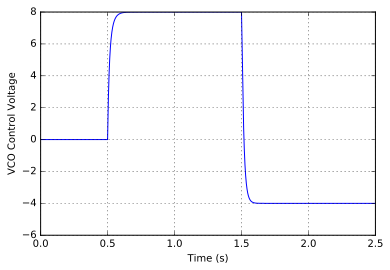

In [13]:
plot(t,ev)
#plot(t,psi)
xlabel(r'Time (s)')
ylabel(r'VCO Control Voltage')
grid();

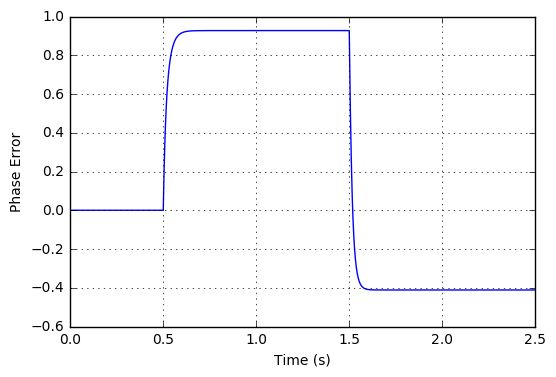

In [275]:
#plot(t,ev)
plot(t,psi)
xlabel(r'Time (s)')
ylabel(r'Phase Error')
grid();

### Making Sense of the Phase Plane
The phase plane plot is $d\psi(t)/dt$ versus $\psi(t)$. We can form this plot by taking the outputs of the PLL simulation and doing some further signal processing.

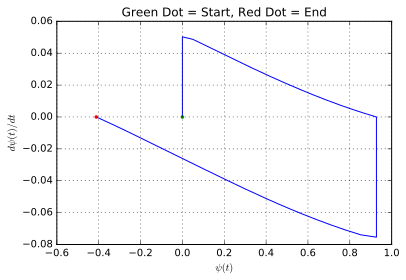

In [7]:
psi_dot = diff(psi)
plot(psi[:-1],psi_dot)
plot(psi[0],psi_dot[0],'g.')
plot(psi[-2],psi_dot[-1],'r.')
title(r'Green Dot = Start, Red Dot = End')
xlabel(r'$\psi(t)$')
ylabel(r'$d\psi(t)/dt$')
grid();

## Second-Order Loop Simulation

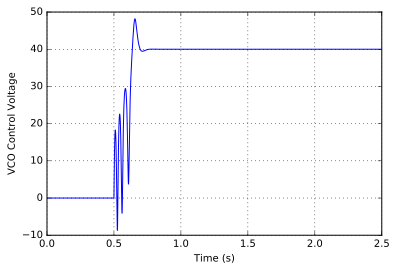

In [8]:
t = arange(0,2.5,1/1000)
#phi = 2*pi*8*((t-0.5)*ssd.step(t-0.5)) - 2*pi*12*((t - 1.5)*ssd.step(t-1.5))
phi = 2*pi*40*((t-0.5)*ssd.step(t-0.5))
theta_hat, ev, psi = pll.PLL1(phi,1000,2,1,10,0.707,1)
plot(t,ev)
#plot(t,psi)
xlabel(r'Time (s)')
ylabel(r'VCO Control Voltage')
grid();

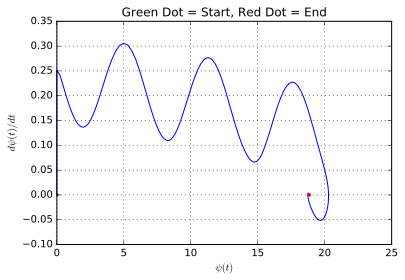

In [9]:
psi_dot = diff(psi)
plot(psi[:-1],psi_dot)
plot(psi[0],psi_dot[0],'g.')
plot(psi[-2],psi_dot[-1],'r.')
title(r'Green Dot = Start, Red Dot = End')
xlabel(r'$\psi(t)$')
ylabel(r'$d\psi(t)/dt$')
grid();

# Complex Baseband PLL
Here we consider a PLL that operates with a complex signal input, simply the phase of the input. The function `pll.PLL_cbb()` is a rework of `PLL1()` to allow a complex signal input using a sinusoidal phase detector. **Note**: There is an annoying bug in `synchronization.py` which is now fixed and is included in the ZIP package for the Chapter 4 notebook.

With the simulation code below you can model a PLL at the full waveform level, not just phase 
in/phase out, as is done in `PLL1`. A sinusoidal phase detector is employed which forms as output
\begin{align}
    e_d(t) &= \text{Re}\left[x_r(t)\cdot e_o^\ast(t)\right]
\end{align} where the now complex signals $x_r(t)$ and $e_o(t)$ are of the form
\begin{align}
    x_r(t) &= A_c e^{j [2\pi f_c t + \phi(t)]} \\
    e_o(t) &= e^{j \theta(t)}
\end{align} In advanced applications $x_r(t)$ may also include a noise signal. In what follows $A_c = 1$ to insure that the internal gain scaling for the loop parameters remains calibrated.

For the special homework problem the example allows you to study the sinusoidal FM response of the PLL. The FM modulation input is setup in the lines:
```python
# Sinusoidal modulation at fm Hz and fD Hz peak deviation
Am = 1
fD = 1
fm = 10
phi = fD/fm*Am*cos(2*pi*fm*t) #2*p removed from earlier versions and replaced with Am
```

Under linear operation of the loop the VCO control signal $e_v(t)$ is the sinusoidal response to the input message $m(t) = A_m\cos(2\pi f_m t + \phi_m)$, where here $A_m = 1$ and $\phi_m = 0$. From the loop linear theory the amplitude of $e_v(t)$, in steady-state is
\begin{align}
    \big|E_v(j2\pi f_m)\big| &= \frac{k_f}{K_v} A_m |e^{j\phi_m}| \big|H(j2\pi f_m)\big| = \frac{f_D}{K'_v} A_m |e^{j\phi_m}| \big|H(j2\pi f_m)\big| 
\end{align}
where $H(j2\pi f) = H(s)|_{s=j2\pi f}$ is the frequency response of the closed-loop transfer function. Recall also that for an FM modulator $k_f = 2\pi f_D$ and $K_v$, the VCO gain constant includes a $2\pi$ when one considers the VCO gain in Hz/V. This means that $k_f/K_v$ simplifies to $f_D/K'_v$, where the $K'_v$ has units of Hz/V, i.e., $K_v = 2\pi K'_v$. In the simulation below $K'_v = 1$,  $A_m = 1$, and $f_D=1$, so the expected peak amplitude of $e_v(t)$ is $|H(j2\pi f_m)|$.

To evaluate $|H(j2\pi f_m)|$ in Python consider the first-order loop:

In [22]:
f = arange(0,20,1)
# H(f) = K_t/(s + K_t) with s = 2*pi*f and Kt = 2*pi*fn, so
# H(f) = f/(1j*f + fn)
fn = 10
magH = abs(fn/(1j*f + fn))
magH

array([ 1.        ,  0.99503719,  0.98058068,  0.95782629,  0.92847669,
        0.89442719,  0.85749293,  0.81923192,  0.78086881,  0.74329415,
        0.70710678,  0.67267279,  0.6401844 ,  0.60971076,  0.58123819,
        0.5547002 ,  0.52999894,  0.50702013,  0.48564293,  0.46574643])

* Note at `f = 10`, `magH = 0.707` as expected!
* For the second-order loop things are a bit more complicated because $H(f)$ from notes page 4-42 & 4-43 is of the form
\begin{align}
    H(f) &= H(s)|_{s=j2\pi f} \\
    \text{where}\ H(s) &= \frac{K_t (s+a)}{s^2 + K_t a s + K_t a} = \frac{K_t(s + a)}{s^2 + 2\zeta\omega_n s + \omega_n^2},
\end{align} $\omega_n = 2\pi f_n$, and $a$ and $K_t$ can be written in terms of $\omega_n$ and the damping $\zeta$.

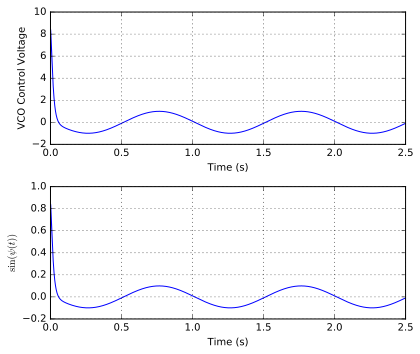

In [20]:
t = arange(0,2.5,1/1000)
# Carrier frequency step
Df = 0
f0 = 0
f0 = Df*ssd.step(t-0.5)
# Sinusoidal modulation at fm Hz and fD Hz peak deviation
Am = 1
fD = 1
fm = 1
phi = fD/fm*Am*cos(2*pi*fm*t)
x = exp(1j*(2*pi*f0*t+phi)) # modulation is phi
# cpx input, fs, loop_type (1, 2, or 3), Kv (V/Hz), fn (Hz), zeta
theta_hat, ev, psi = pll.PLL_cbb(x,1000,1,1,10,0.707)
figure(figsize=(6,5))
subplot(211)
plot(t,ev)
xlabel(r'Time (s)')
ylabel(r'VCO Control Voltage')
grid();
subplot(212)
plot(t,psi)
xlabel(r'Time (s)')
ylabel(r'$\sin(\psi(t))$')
grid();
tight_layout()

* As expected the peak value of $e_v(t)$ (`ev`) in steady-state is about 1 when $f_m \ll f_n$

# Discriminator with Tone Interference

In [280]:
fs = 10000
t = arange(0,1,1/fs)
Ac = 1.0
Ai = 0.01
fi = 100
xr = 1 + Ai*exp(1j*2*pi*fi*t) 

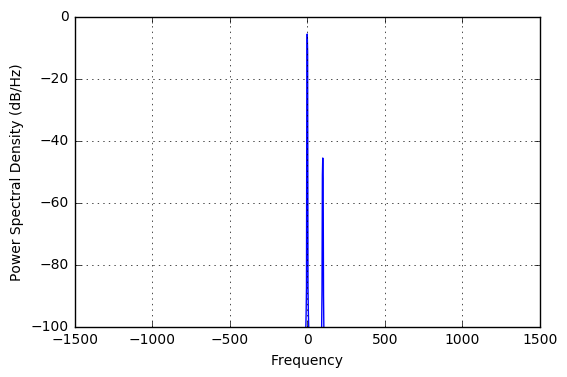

In [281]:
psd(xr,2**12,fs);
xlim([-1500,1500])
ylim([-100,0]);

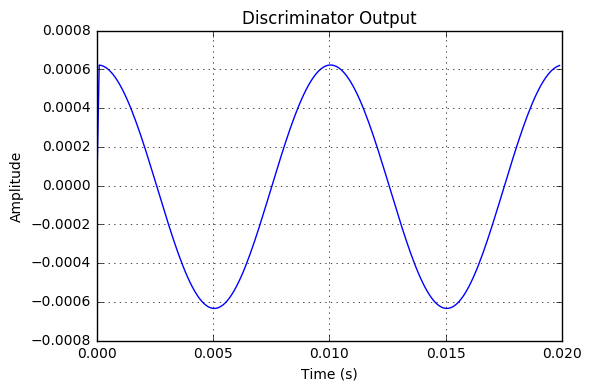

In [282]:
yD = discrim(xr)
plot(t[:200],yD[:200])
title(r'Discriminator Output')
ylabel(r'Amplitude')
xlabel(r'Time (s)')
grid();

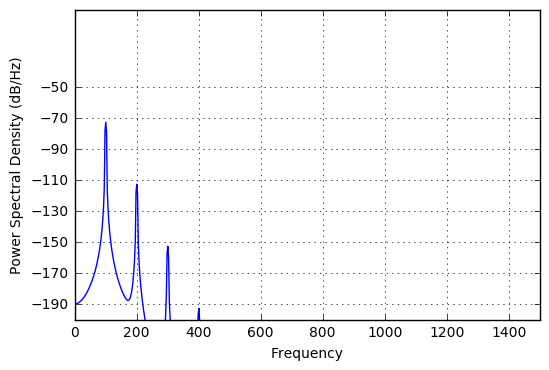

In [283]:
psd(yD,2**12,fs);
xlim([0,1500])
ylim([-200,0]);

## Tone Plus Bandlimited Noise Interference

In [284]:
W = 1000
b,a = signal.butter(12,2*W/fs)
w = (randn(len(xr)) + 1j*randn(len(xr)))*.05
wf = signal.lfilter(b,a,w)

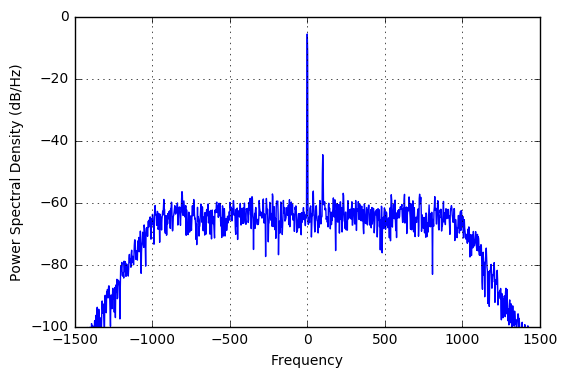

In [285]:
psd(xr+wf,2**12,fs);
xlim([-1500,1500])
ylim([-100,0]);

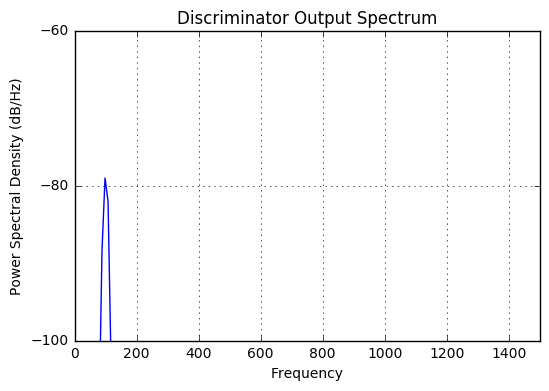

In [286]:
psd(yD,2**10,fs);
title(r'Discriminator Output Spectrum')
xlim([0,1500])
ylim([-100,-60]);

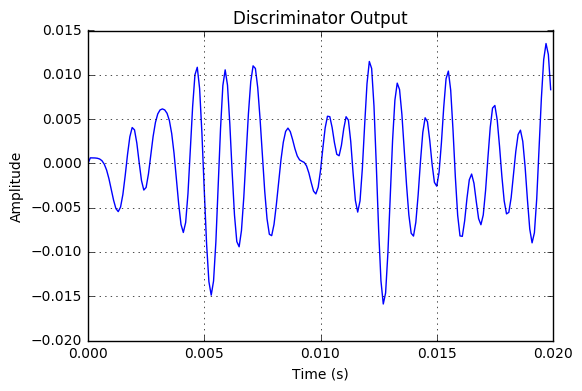

In [287]:
yD = discrim(xr+wf)
plot(t[:200],yD[:200]);
title(r'Discriminator Output')
ylabel(r'Amplitude')
xlabel(r'Time (s)')
grid();